In [1]:
import sys
import logging

import numpy as np
import matplotlib.pyplot as plt

import gym
from gym.wrappers import AtariPreprocessing, FrameStack
from gym.spaces import Box

from stable_baselines3 import A2C, PPO, DQN
from stable_baselines3.common.cmd_util import make_atari_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eric/Co

# baseline with a vector environment:

In [62]:
device = 'cpu' # at this moment, my desktop at home is strapped for memory

In [19]:
venv = VecFrameStack(make_atari_env('BreakoutNoFrameskip-v4'), n_stack=4)
obs = venv.reset()
print(type(obs), obs.shape)

<class 'numpy.ndarray'> (1, 84, 84, 4)


In [20]:
model = A2C('CnnPolicy', venv, verbose=1, device=device)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [21]:
venv.observation_space

Box(84, 84, 4)

### It's working fine! Let's try a frame-stacked atari environment which is not a VectorEnv

In [46]:
class VanillaFrameStack(FrameStack):
    """Stacks frames but without using LazyFrame nonsense."""

    def __init__(self, env, n_stack=4):
        """ 
        Wraper for `env` which stacks `n_stack` frames.

        Args:
            env (gym.Env): Environment to wrap
            n_stack (int): Number of observations to stack
        """
        super(VanillaFrameStack, self).__init__(env, n_stack)
        self.observation_space = Box(0, 255, shape=[84, 84, 4], dtype=env.observation_space.dtype)

    def _get_observation(self):
        assert len(self.frames) == self.num_stack, (len(self.frames), self.num_stack)
        stack = np.array(list(self.frames)) # if atari, then shape (4, 84, 84)
        stack = np.transpose(stack, axes=(1, 2, 0)) # (84, 84, 4)
#         stack = np.expand_dims(stack, axis=0) # (1, 84, 84, 4)
        return stack

In [47]:
env = gym.make('BreakoutNoFrameskip-v4')
env = AtariPreprocessing(env, frame_skip=1)
env = VanillaFrameStack(env, n_stack=4)
obs = env.reset()
print(type(obs), obs.shape)

<class 'numpy.ndarray'> (84, 84, 4)


In [48]:
model = A2C('CnnPolicy', env, verbose=1, device=device)

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


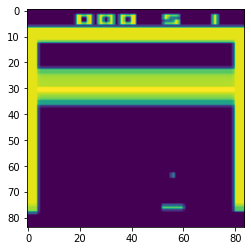

In [56]:
for _ in range(10):
    obs, _, _, _ = env.step(1)
plt.imshow(obs[..., 0])

In [66]:
model = A2C.load('../agents/a2c/BreakoutNoFrameskip-v4_3/BreakoutNoFrameskip-v4.zip', device='cpu')


AttributeError: 'Box' object has no attribute '_np_random'

In [68]:
A2C.learn?

In [18]:
env = gym.make('BreakoutNoFrameskip-v4')
env = AtariPreprocessing(env, frame_skip=1)
env = VanillaFrameStack(env, n_stack=4)
obs = env.reset()
print(type(obs), obs.shape)
venv = DummyVecEnv([lambda: env])
obs = venv.reset()
print(type(obs), obs.shape)

<class 'numpy.ndarray'> (1, 84, 84, 4)


ValueError: could not broadcast input array from shape (84,84,4) into shape (4,84,84)

In [9]:
model = A2C('CnnPolicy', venv, verbose=1, device=device)

Using cpu device
Wrapping the env in a VecTransposeImage.


RuntimeError: Calculated padded input size per channel: (4 x 84). Kernel size: (8 x 8). Kernel size can't be greater than actual input size

## so observations with the exact same work with vector environments and fail with my custom environment!!?? maybe this is an issue with the DummyVecEnv adding a dimension?

In [10]:
class VanillaFrameStack(FrameStack):
    """Stacks frames but without any LazyFrame nonsense."""

    def __init__(self, env, n_stack=4):
        """ 
        Wraper for `env` which stacks `n_stack` frames.

        Args:
            env (gym.Env): Environment to wrap
            n_stack (int): Number of observations to stack
        """
        super(VanillaFrameStack, self).__init__(env, n_stack)

    def _get_observation(self):
        assert len(self.frames) == self.num_stack, (len(self.frames), self.num_stack)
        stack = np.array(list(self.frames)) # if atari, then shape (4, 84, 84)
        stack = np.transpose(stack, axes=(1, 2, 0)) # (84, 84, 4)
#         stack = np.expand_dims(stack, axis=0) # (1, 84, 84, 4)
        return stack

In [11]:
env = gym.make('BreakoutNoFrameskip-v4')
env = AtariPreprocessing(env, frame_skip=1)
env = VanillaFrameStack(env, n_stack=4)
obs = env.reset()
print(type(obs), obs.shape)

<class 'numpy.ndarray'> (84, 84, 4)


In [12]:
model = A2C('CnnPolicy', env, verbose=1, device=device)

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


RuntimeError: Calculated padded input size per channel: (4 x 84). Kernel size: (8 x 8). Kernel size can't be greater than actual input size

## Nope! this fails too!

I've also tried:
* (4, 84, 84)
* (1, 4, 84, 84)

And they also fail. What's going on here?

In [14]:
env = gym.make('BreakoutNoFrameskip-v4')
env = AtariPreprocessing(env, frame_skip=1)
env = VanillaFrameStack(env, n_stack=4)
obs = env.reset()
print(type(obs), obs.shape)
venv = DummyVecEnv([lambda: env])
obs = venv.reset()
print(type(obs), obs.shape)

<class 'numpy.ndarray'> (84, 84, 4)


ValueError: could not broadcast input array from shape (84,84,4) into shape (4,84,84)

In [ ]:
model = A2C('CnnPolicy', venv, verbose=1, device=device)

In [20]:
class VanillaFrameStack(FrameStack):
    """Stacks frames but without any LazyFrame nonsense."""

    def __init__(self, env, n_stack=4):
        """ 
        Wraper for `env` which stacks `n_stack` frames.

        Args:
            env (gym.Env): Environment to wrap
            n_stack (int): Number of observations to stack
        """
        super(VanillaFrameStack, self).__init__(env, n_stack)

    def _get_observation(self):
        assert len(self.frames) == self.num_stack, (len(self.frames), self.num_stack)
        stack = np.array(list(self.frames)) # if atari, then shape (4, 84, 84)
#         stack = np.transpose(stack, axes=(1, 2, 0)) # (84, 84, 4)
#         stack = np.expand_dims(stack, axis=0) # (1, 84, 84, 4)
        return stack

In [21]:
env = gym.make('BreakoutNoFrameskip-v4')
env = AtariPreprocessing(env, frame_skip=1)
env = VanillaFrameStack(env, n_stack=4)
obs = env.reset()
print(type(obs), obs.shape)
venv = DummyVecEnv([lambda: env])
obs = venv.reset()
print(type(obs), obs.shape)

<class 'numpy.ndarray'> (4, 84, 84)
<class 'numpy.ndarray'> (1, 4, 84, 84)


In [22]:
model = A2C('CnnPolicy', venv, verbose=1, device=device)

Using cpu device
Wrapping the env in a VecTransposeImage.


RuntimeError: Calculated padded input size per channel: (4 x 84). Kernel size: (8 x 8). Kernel size can't be greater than actual input size

In [23]:
class VanillaFrameStack(FrameStack):
    """Stacks frames but without any LazyFrame nonsense."""

    def __init__(self, env, n_stack=4):
        """ 
        Wraper for `env` which stacks `n_stack` frames.

        Args:
            env (gym.Env): Environment to wrap
            n_stack (int): Number of observations to stack
        """
        super(VanillaFrameStack, self).__init__(env, n_stack)

    def _get_observation(self):
        assert len(self.frames) == self.num_stack, (len(self.frames), self.num_stack)
        stack = np.array(list(self.frames)) # if atari, then shape (4, 84, 84)
#         stack = np.transpose(stack, axes=(1, 2, 0)) # (84, 84, 4)
        stack = np.expand_dims(stack, axis=0) # (1, 84, 84, 4)
        return stack

In [24]:
env = gym.make('BreakoutNoFrameskip-v4')
env = AtariPreprocessing(env, frame_skip=1)
env = VanillaFrameStack(env, n_stack=4)
obs = env.reset()
print(type(obs), obs.shape)
venv = DummyVecEnv([lambda: env])
obs = venv.reset()
print(type(obs), obs.shape)

<class 'numpy.ndarray'> (1, 4, 84, 84)
<class 'numpy.ndarray'> (1, 4, 84, 84)


In [26]:
env.reset().shape

(1, 4, 84, 84)

In [27]:
env.observation_space

Box(4, 84, 84)

In [25]:
model = A2C('CnnPolicy', venv, verbose=1, device=device)

Using cpu device
Wrapping the env in a VecTransposeImage.


RuntimeError: Calculated padded input size per channel: (4 x 84). Kernel size: (8 x 8). Kernel size can't be greater than actual input size